# Processing Data and Plotting Descriptors Examples

#### This notebook demonstrates the power of the package, and its ability to clean battery cycling data, build a model fit individualized to every cycle, and gather peak descriptors. This notebook will use data from the CALCE website: https://www.calce.umd.edu/batteries/data.htm. The package is able to process data from MACCOR cyclers as well, but for the purpose of this notebook we will demonstrate the functionality using the CALCE data. 

### First we import everything we need:

In [2]:
import glob
import itertools
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import peakutils
import scipy
import sqlite3 as sql

from diffcapanalyzer.databasewrappers import process_data
from diffcapanalyzer.databasewrappers import get_filename_pref
from diffcapanalyzer.databasefuncs import init_master_table
from diffcapanalyzer.databasefuncs import get_file_from_database
from diffcapanalyzer.descriptors import generate_model


%matplotlib inline

## Processing Data Through the Notebook

### We can use the process_one_file function, which takes raw data and cleans it, and builds and fits the models to generate cycle descriptors. Then we can plot those descriptors and see how they evolve through the cycles. 

## Process One File: 

In [3]:
def process_one_file(df, save_as_name, database, datatype, windowlength = 9,
                     polyorder = 3, peak_thresh = 0.7, save_to_excel = False):
    if not os.path.exists(database): 
        init_master_table(database)
    cleanset_name = save_as_name + 'CleanSet'
    if datatype == 'ARBIN':
        df['datatype'] = 'ARBIN'
        expected_cols = [
            'Cycle_Index',
            'Voltage(V)',
            'Current(A)',
            'Charge_Capacity(Ah)',
            'Discharge_Capacity(Ah)',
            'Step_Index']
        assert all(item in list(df.columns) for item in expected_cols)
    elif datatype == 'MACCOR':
        df['MaccCharLab'] = df.apply(
            lambda row: macc_chardis(row), axis=1)
        df['Current(A)'] = df['Current [A]'] * df['MaccCharLab']
        df['datatype'] = 'MACCOR'
        expected_cols = [
            'Cycle C',
            'Voltage [V]',
            'Current [A]',
            'Cap. [Ah]',
            'Md']
        assert all(item in list(df.columns) for item in expected_cols)
        df.rename(
            columns={
                'Cycle C': 'Cycle_Index',
                'Voltage [V]': 'Voltage(V)',
                'Current [A]': 'Abs_Current(A)',
                'Cap. [Ah]': 'Cap(Ah)'},
            inplace=True)
    process_data(
        save_as_name,
        database,
        df,
        datatype,
        windowlength,
        polyorder)
    df_clean = get_file_from_database(cleanset_name, database)
    feedback = generate_model(
        df_clean, save_as_name, peak_thresh, database)
    descriptors_df = get_file_from_database(save_as_name + '-descriptors', database)
    if save_to_excel: 
        writer = pd.ExcelWriter(save_as_name + '-descriptors.xlsx')
        descriptors_df.to_excel(writer, 'Sheet1')
        writer.save()
    return descriptors_df

In [4]:
df = pd.read_csv(os.path.join('../data/ARBIN/CS2_33/CS2_33_8_30_10.csv'))
database = 'example_db.db'
base_filename = 'CS2_33_8_30_10'
datatype = 'ARBIN'

descriptors_df = process_one_file(df, base_filename, database, datatype, peak_thresh = 0.3)

## Now that the raw data has been processed, we can plot it and look at our peak descriptors

In [5]:
# First let's define some variable names
# If you are interested in plotting something other than 
# the file that was just processed, simply change the base_filename
# variable to the file name in the database you wish to plot. 

raw_filename = base_filename + "Raw"
model_filename = base_filename + "-ModPoints"
descriptors_filename = base_filename + "-descriptors"
clean_filename = base_filename + "CleanSet"

#### First let's plot the raw dQ/dV curve of an example cycle, with the model overlaid. 

(-10, 10)

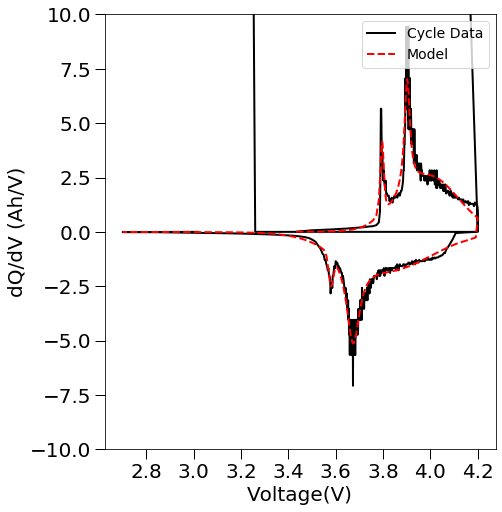

In [6]:
raw_df = get_file_from_database(raw_filename, database)
mod_df = get_file_from_database(model_filename, database)

fig1 = plt.figure(figsize = (7,8), facecolor = 'w', edgecolor= 'k')
# create the color map based off of the max value in the cycle index column
colors = matplotlib.cm.Greys(np.linspace(0.3, 1, int(max(raw_df['Cycle_Index']))))

cycle_to_plot = 1
# plot cycle 1, this number can be changed to any cycle

for name, group in raw_df.groupby(['Cycle_Index']):
    if name == cycle_to_plot:
        plt.plot(group['Voltage(V)'], group['dQ/dV'], c = 'black', linewidth = 2, label = 'Cycle Data') 

for name, group in mod_df.groupby(['Cycle_Index']): 
    if name == cycle_to_plot:
        plt.plot(group['Voltage(V)'], group['Model'], c = 'red', linewidth = 2, label = 'Model', linestyle = '--')

plt.legend()
leg = plt.legend(loc = 'upper right', fontsize = 14)
plt.ylabel('dQ/dV (Ah/V)', fontsize =20)
plt.xlabel('Voltage(V)', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(size = 10, width = 1)

# plt.xlim(0, 4)
plt.ylim(-10,10)

# Uncomment the following line if you would like to save the plot. 
# plt.savefig(fname = 'MyExampleCycle.png', bbox_inches='tight', dpi = 600)


#### We can also examine how accurate the peak finding was by plotting the curve along with the peak locations and heights:

(-10, 10)

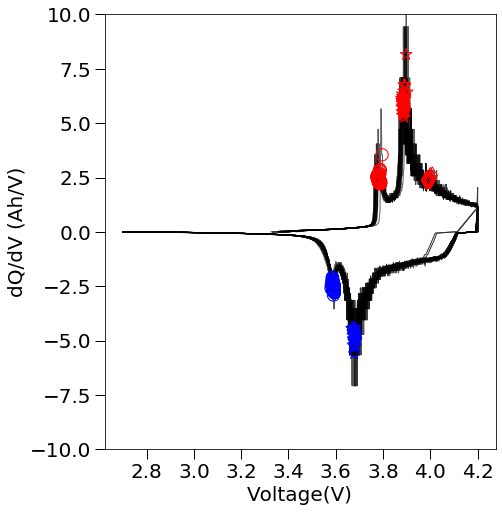

In [7]:
charge_peak_numbers_to_plot = [1, 2, 4]
discharge_peak_numbers_to_plot = [1, 2, 4]

clean_df = get_file_from_database(clean_filename, database)
descriptors_df = get_file_from_database(descriptors_filename, database)

fig1 = plt.figure(figsize = (7,8), facecolor = 'w', edgecolor= 'k')

# create the color map based off of the max value in the cycle index column
colors = matplotlib.cm.Greys(np.linspace(0.7, 1, int(max(clean_df['Cycle_Index']))))

# create a list of markers to use for each peak
marker_c = itertools.cycle(('o', '*', 'd', 'P', '^', 's')) 
marker_d = itertools.cycle(('o', '*', 'd', 'P', '^', 's')) 

for name, group in clean_df.groupby(['Cycle_Index']):
    # Uncomment the following line if you only want a subset of cycles, and fill in which cycle numbers to plot. 
    # if name == 1 or name == 2:
    plt.plot(group['Voltage(V)'], group['dQ/dV'], c = colors[name-1], linewidth = 1, label = 'Cycle' + str(name)) 

for peak_num in charge_peak_numbers_to_plot: 
    location = "sortedloc-c-" + str(peak_num)
    height = "sortedactheight-c-" + str(peak_num)
    if location in descriptors_df.columns and height in descriptors_df.columns:
        plt.scatter(descriptors_df[location], descriptors_df[height], facecolors = 'none', 
                    edgecolor = 'red', zorder = 5, s = 150, marker = next(marker_c), alpha = 1, 
                    label = 'charge peak ' + str(peak_num))

for peak_num in discharge_peak_numbers_to_plot:
    location = "sortedloc-d-" + str(peak_num)
    height = "sortedactheight-d-" + str(peak_num)
    if location in descriptors_df.columns and height in descriptors_df.columns:
        plt.scatter(descriptors_df[location], -descriptors_df[height], facecolors = 'none', 
                    edgecolor = 'blue', zorder = 5, s = 150, marker = next(marker_d), alpha = 1, 
                    label = 'discharge peak ' + str(peak_num))
    
# for the discharge peak height there has to be a negative sign on the height since the descriptors gathered are an absolute value

plt.ylabel('dQ/dV (Ah/V)', fontsize =20)
plt.xlabel('Voltage(V)', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(size = 10, width = 1)

# plt.legend()

# plt.xlim(0,1)
plt.ylim(-10,10)

# plt.savefig(fname = 'ExampleWithDescriptors.png', bbox_inches='tight', dpi = 600)

#### Or we may be interested in plotting the peak descriptor values and comparing them over cycles. 

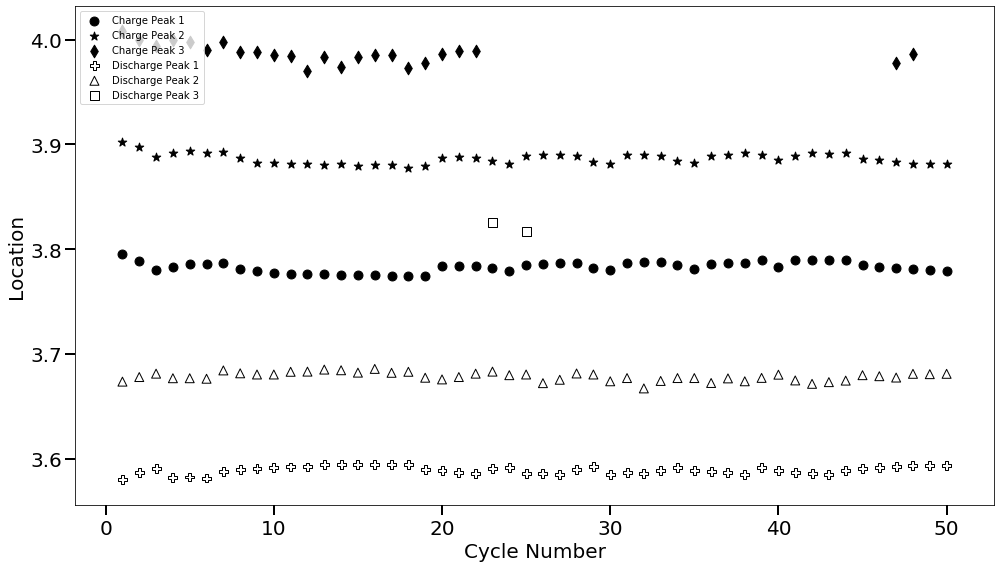

In [8]:
descriptors_df = get_file_from_database(descriptors_filename, database)

# The following variables can be filled out to customize the plot
descriptors_to_plot = ["Location", "Height"]
# Can only be two (because only two axes)
# Can be "Location", "Height", "Area", "Sigma", "Amplitude", "FWHM", and/or "Pseudo Voigt Fraction"

charge_peak_numbers_to_plot = [1, 2, 3]
discharge_peak_numbers_to_plot = [1, 2, 3]

# This dictionary is to translate between how the descriptors are saved in the database and how they are typed 
short_hand_dictionary = {"Location": "loc", "Height": "actheight", "Area": "area", "Sigma": "SIGMA", 
                                 "Amplitude": "amplitude", "FWHM": "fwhm", "Pseudo Voigt Fraction": "fraction"}

# Descriptor 1:
descriptor1 = descriptors_to_plot[0]

fig, ax1 = plt.subplots(figsize = (14,8), facecolor = 'w', edgecolor = 'k')
ax1.set_xlabel("Cycle Number", fontsize = 20)
ax1.set_ylabel(descriptor1, fontsize =20)
marker = itertools.cycle(('o', '*', 'd', 'P', '^', 's'))


for peak_num in charge_peak_numbers_to_plot:
    column_name = "sorted" + short_hand_dictionary[descriptor1] + "-c-" + str(peak_num)
    if column_name in descriptors_df.columns:
        ax1.scatter(descriptors_df["c_cycle_number"], descriptors_df[column_name], color = 'black', marker = next(marker), 
                    s = 80, label = "Charge Peak " + str(peak_num))
    ax1.tick_params(size = 10, width = 2, labelsize = 20)

    
for peak_num in discharge_peak_numbers_to_plot:
    column_name = "sorted" + short_hand_dictionary[descriptor1] + "-d-" + str(peak_num)
    if column_name in descriptors_df.columns:
        ax1.scatter(descriptors_df["d_cycle_number"], descriptors_df[column_name], facecolor = 'none', 
                    edgecolors= 'black', marker = next(marker), s = 80, label = "Discharge Peak " + str(peak_num))
    ax1.tick_params(size = 10, width = 2, labelsize = 20)

ax1.legend(loc = "upper left")
    
fig.tight_layout()  
# otherwise the right y-label is slightly clipped

# plt.savefig(fname = 'PeakDescriptorsOverCycles.png', bbox_inches='tight', dpi = 600)


#### Peak area ratios can also be interesting to plot over cycle numbers:

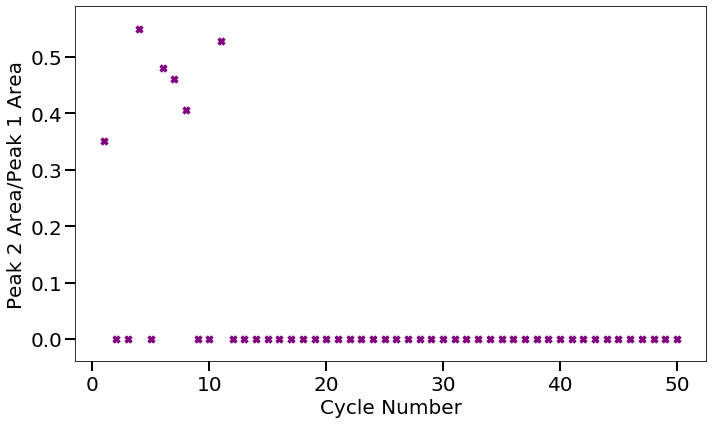

In [9]:
descriptors_df = get_file_from_database(descriptors_filename, database)
fig, ax1 = plt.subplots(figsize = (10,6), facecolor = 'w', edgecolor = 'k')

# Put in which two peak numbers we are comparing as the ratios. This is plotted as peak1/peak2 = peak area ratio. 
peak1 = 1
peak2 = 2

ax1.set_ylabel("Peak " + str(peak2) + " Area/" + "Peak " + str(peak1) + " Area", fontsize =20) 
ax1.set_xlabel('Cycle Number', fontsize = 20)
column_name1 = "sortedarea-c-" + str(peak1)

# change the c or d in each of these corresponding to charge (c) or discharge (d)
column_name2 = "sortedarea-c-" + str(peak2)

if column_name1 in descriptors_df.columns and column_name2 in descriptors_df.columns:
    ax1.scatter(descriptors_df['c_cycle_number'], 
                descriptors_df[column_name1]/descriptors_df[column_name2],
                color = 'purple', s = 50, marker = 'X')

#ax1.set_ylim([0, 7])

ax1.tick_params(size = 10, width = 2, labelsize = 20)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

# plt.savefig(fname = 'PeakAreaRatios.png', bbox_inches='tight', dpi = 600)